In [1]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

In [2]:
from pandas import read_csv
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from os.path import isfile
from tqdm import tqdm_notebook as tqdm
import random
from random import shuffle
import os
import math
import tensorflow as tf
from datetime import datetime
import keras
from keras.engine.topology import Layer
from keras import backend as K
from keras.initializers import Constant
import tensorflow as tf
from keras.utils.generic_utils import get_custom_objects
from keras.models import Model
import math

from PIL import Image as pil_image
from tqdm import tqdm_notebook

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tqdm import tqdm_notebook as tqdm
from keras_tqdm import TQDMNotebookCallback
from sklearn.utils import shuffle
from keras.callbacks import CSVLogger


Using TensorFlow backend.


In [3]:
shape = (112,96,3)
num_classes = 10575

In [4]:
def get_lfw_list(index_file_path):
    with open(index_file_path, 'rb') as index_file:
        split_lines = [ln.decode().strip().split('\t') for ln in index_file]
    return split_lines

In [5]:
#print(os.listdir('../datasets/lfw/all_masked_bbox/'))


data = get_lfw_list('../datasets/lfw/pairs.txt')
data = data[2:]

In [6]:
print(data[5555])
test_X = []
pair1 = []
pair2 = []
label = []

for pairs in tqdm(data):
    if len(pairs)==3:
        number = str(pairs[1])
        if len(number)==1:number = '000'+number
        if len(number)==2:number = '00'+number
        if len(number)==3:number = '0'+number
        pair1_path = str(pairs[0])+':'+number+'.jpg'
        number = str(pairs[2])
        if len(number)==1:number = '000'+number
        if len(number)==2:number = '00'+number
        if len(number)==3:number = '0'+number
        pair2_path = str(pairs[0])+':'+number+'.jpg'
        
        pair1.append(pair1_path)
        pair2.append(pair2_path)
        label.append(1)
        
        test_X.append(pair1_path)
        test_X.append(pair2_path)
    if len(pairs)==4:
        number = str(pairs[1])
        if len(number)==1:number = '000'+number
        if len(number)==2:number = '00'+number
        if len(number)==3:number = '0'+number
        pair1_path = str(pairs[0])+':'+number+'.jpg'
        number = str(pairs[3])
        if len(number)==1:number = '000'+number
        if len(number)==2:number = '00'+number
        if len(number)==3:number = '0'+number
        pair2_path = str(pairs[2])+':'+number+'.jpg'
        
        pair1.append(pair1_path)
        pair2.append(pair2_path)
        label.append(0)
        

['John_Bolton', '6', '7']


In [7]:
df = pd.DataFrame(data=pair1, columns=['pair1'])
df['pair2'] = pair2
df['label'] = label

In [8]:
df.head()

,pair1,pair2,label
0,Akhmed_Zakayev:0001.jpg,Akhmed_Zakayev:0003.jpg,1
1,Akhmed_Zakayev:0002.jpg,Akhmed_Zakayev:0003.jpg,1
2,Amber_Tamblyn:0001.jpg,Amber_Tamblyn:0002.jpg,1
3,Anders_Fogh_Rasmussen:0001.jpg,Anders_Fogh_Rasmussen:0003.jpg,1
4,Anders_Fogh_Rasmussen:0001.jpg,Anders_Fogh_Rasmussen:0004.jpg,1


In [9]:
test = []
for i in range(len(df)):
    pair=[]
    pair.append(df['pair1'].iloc[i])
    pair.append(df['pair2'].iloc[i])
    test.append(pair)
    

In [10]:
#print(test)

In [11]:
import random
from keras import backend as K
from keras.preprocessing.image import img_to_array,array_to_img
import cv2
from matplotlib import pyplot as plt
import numpy as np

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

def strong_aug(p=0.7):
    return Compose([
        #RandomRotate90(),
        #Flip(),
        #HorizontalFlip(),
        #OneOf([
        #    IAAAdditiveGaussianNoise()
        #], p=0.3),
        #OneOf([
        #    MotionBlur(p=0.3),
        #    MedianBlur(blur_limit=1, p=0.3),
        #    Blur(blur_limit=1, p=0.3),
        #], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=30, p=0.5,border_mode=0),
        #CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.35),
        #OneOf([
        #    IAASharpen(),
        #    IAAEmboss(),
        #], p=0.3),
    ], p=p)

aug = strong_aug(p=0.8)

In [12]:
img_shape = shape

def read_cropped_image(p, augment):
    """
    @param p : the name of the picture to read
    @param augment: True/False if data augmentation should be performed
    @return a numpy array with the transformed image
    """
    # Read the image, transform to black and white and comvert to numpy array
    img   = read_raw_image(p)#.convert('L')
    img   = img_to_array(img)
        
    img   = img.astype('uint8')
    
    
    if img.shape[2] == 1:
        img = np.stack((img[..., 0],) * 3, axis=-1)
    
    if augment:
        augmented = aug(image=img)
        img = augmented['image']

    
    img = cv2.resize(img,(img_shape[1],img_shape[0]))

    img   = img.astype('float64')
    #img = img.astype('uint8')
    # Normalize to zero mean and unit variance
    img  -= np.mean(img, keepdims=True)
    img  /= np.std(img, keepdims=True) #+ K.epsilon()
    #img = img.reshape(img.shape[0],img.shape[1],1)
    
    
    return img

In [75]:
#MODEL HEREEEE
import keras
from keras.applications.resnet50 import ResNet50

backbone = ResNet50(input_shape=shape, weights='imagenet', include_top=False)

In [76]:
from Angular_loss import *

model = create_model(shape,backbone,64e-2,num_classes)

In [77]:
print(os.listdir('../'))

['model', 'datasets', 'state-of-art']


In [78]:
#Model 2
#model.load_weights('../state-of-art/model-checkpoint/Casia/Arcface-UNMASKED-112x112-3.826-0.888.model')
#Model 3
#model.load_weights('../state-of-art/model-checkpoint/Casia/Arcface-UNMASKED-MASKED-0.9650-0.23.model')
#Model 1
#model.load_weights('../state-of-art/model-checkpoint/Casia/Arcface-MASKED-112x112-23-12.932-0.020-20190424_110959.model')
#Model Progressive + masked
model.load_weights('../state-of-art/model-checkpoint/Casia/Arcface-PROGRESSIVE_MASK-112x96-20-6.109-0.823.model')

In [79]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 112, 96, 3)        0         
_________________________________________________________________
resnet50 (Model)             (None, 4, 3, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_with__arcface_loss_5 ( (None, 10575)             21657600  
Total params: 45,253,504
Trainable params: 45,196,288
Non-trainable params: 57,216
_________________________________________________________________


In [80]:
layer_name = model.layers[-2].name
model = Model(inputs=model.input,
                        outputs=model.get_layer(layer_name).output)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 112, 96, 3)        0         
_________________________________________________________________
resnet50 (Model)             (None, 4, 3, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 2048)              8192      
Total params: 23,595,904
Trainable params: 23,538,688
Non-trainable params: 57,216
_________________________________________________________________


In [81]:
class TestingGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs,batch_size=32, dim=(112,112) ,n_classes=num_classes,n_channels=3,
                 shuffle=False,augmentation=False):
        'Initialization'
        self.dim = dim
        self.list_IDs = list_IDs
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.n_channels = n_channels
        self.augmentation = augmentation
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor((len(self.list_IDs) / self.batch_size) ))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X = self.__data_generation(list_IDs_temp)

        return X


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        X = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = read_cropped_image(ID,self.augmentation)

        return X

In [83]:
tr = os.listdir('../datasets/lfw/bbox/')
final_test = []

for pairs in test:
    if pairs[0] in tr:
        if pairs[1] in tr:
            final_test.append(pairs[0])
            final_test.append(pairs[1])

print(len(test))
print(len(test_X))
print(len(final_test))

5999
5998
11998


In [84]:
x1 = []
x2 = []

for i in range(0,len(final_test),2):
    x1.append(final_test[i])
    x2.append(final_test[i+1])
    

print(len(x1))
print(len(x2))

5999
5999


In [85]:
params = {'dim': (img_shape[0],img_shape[1]),
          'batch_size': 1,
          'n_channels': 3,
          'shuffle': False
             }

TRAIN_PATH = '../datasets/lfw/bbox/'

def expand_path(p):
    if isfile(TRAIN_PATH + str(p)): return TRAIN_PATH + str(p)
    return p


def read_raw_image(p):
    img = pil_image.open(expand_path(p))
    #if p in rotate: img = img.rotate(180)
    return img

testing_generator = TestingGenerator(x1 ,**params,augmentation=False)

features1 = model.predict_generator(
        generator=testing_generator,verbose=1)


5999/5999 [==============================] - 81s 14ms/step


In [86]:
backbone = ResNet50(input_shape=shape, weights='imagenet', include_top=False)
model = create_model(shape,backbone,64e-2,num_classes)

#Model 2
#model.load_weights('../state-of-art/model-checkpoint/Casia/Arcface-UNMASKED-112x112-3.826-0.888.model')
#Model 3
#model.load_weights('../state-of-art/model-checkpoint/Casia/Arcface-UNMASKED-MASKED-0.9650-0.23.model')
#Model 1
#model.load_weights('../state-of-art/model-checkpoint/Casia/Arcface-MASKED-112x112-23-12.932-0.020-20190424_110959.model')
#Model Progressive + masked
model.load_weights('../state-of-art/model-checkpoint/Casia/Arcface-PROGRESSIVE_MASK-112x96-20-6.109-0.823.model')

In [87]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 112, 96, 3)        0         
_________________________________________________________________
resnet50 (Model)             (None, 4, 3, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_with__arcface_loss_6 ( (None, 10575)             21657600  
Total params: 45,253,504
Trainable params: 45,196,288
Non-trainable params: 57,216
_________________________________________________________________


In [88]:
layer_name = model.layers[-2].name
model = Model(inputs=model.input,
                        outputs=model.get_layer(layer_name).output)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 112, 96, 3)        0         
_________________________________________________________________
resnet50 (Model)             (None, 4, 3, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 2048)              8192      
Total params: 23,595,904
Trainable params: 23,538,688
Non-trainable params: 57,216
_________________________________________________________________


In [89]:
TRAIN_PATH = '../datasets/lfw/bbox_masked/'

def expand_path(p):
    if isfile(TRAIN_PATH + str(p)): return TRAIN_PATH + str(p)
    return p


def read_raw_image(p):
    img = pil_image.open(expand_path(p))
    #if p in rotate: img = img.rotate(180)
    return img

testing_generator = TestingGenerator(x2 ,**params,augmentation=False)

features2 = model.predict_generator(
        generator=testing_generator,verbose=1)

5999/5999 [==============================] - 86s 14ms/step


In [90]:
def cosin_metric(x1, x2):
    return np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2))

In [91]:
similarity = []
label = []

for i in range(0,len(features1)):
    feature_1 = features1[i]
    feature_2 = features2[i]
    distance = cosin_metric(feature_1,feature_2)
    similarity.append(distance)
    if x1[i].split(':')[0]==x2[i].split(':')[0]:
        label.append(1)
    else:
        label.append(0)
    

In [97]:
print(len(similarity))
print(len(label))
#similarity = np.absolute(similarity)

5999
5999


In [117]:
threshold = 0.445
accuracy = 0

for i in range(len(similarity)):
    if similarity[i]>threshold:
        predicted = 1
    else: predicted = 0
    if predicted == label[i]:
        accuracy += 1

In [118]:
print(accuracy/len(label))

0.9713285547591265


In [119]:
print(len(label))

5999


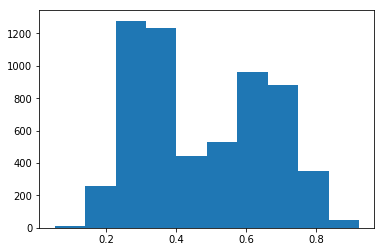

In [96]:
import numpy as np
import matplotlib.pyplot as plt
mu, sigma = 200, 25
x = similarity
n, bins, patches = plt.hist(x)
plt.show()